# Predicoes de series temporais para o preço da Gasolina Comum

Base de dados retirada do Kaggle: https://www.kaggle.com/datasets/lidialucena/sries-temporais

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade xgboost

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from sklearn.metrics import (explained_variance_score,
                             mean_absolute_error,
                             mean_squared_error,
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import datetime as dt
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Tratamento Inicial para a primeira base de dados

Informações da primeira base de dados vai até 2012, a segunda base de dados continua com dados a partir de 2013

In [ ]:
df = pd.read_excel('Brasil.xlsx')

In [ ]:
df.head(15)

,"AGÊNCIA NACIONAL DO PETRÓLEO, GÁS NATURAL E BIOCOMBUSTÍVEIS - ANP",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,COORDENADORIA DE DEFESA DA CONCORRÊNCIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SISTEMA DE LEVANTAMENTO DE PREÇOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RELATÓRIO DE DEFESA DA CONCORRÊNCIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,INTERVALO DE TEMPO: MENSAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PERÍODO: 01/07/2001 A 31/12/2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,COMBUSTÍVEL: TODOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TIPO RELATÓRIO: BRASIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Iremos tratar o Dataframe removendo as colunas com vazios, apenas nos interessa a partir da coluna 11.

In [ ]:
df = df.drop(range(11))

In [ ]:
df.head()

,"AGÊNCIA NACIONAL DO PETRÓLEO, GÁS NATURAL E BIOCOMBUSTÍVEIS - ANP",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
11,MÊS,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PRECO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PRECO MÍNIMO REVENDA,PRECO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PRECO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PRECO MÍNIMO DISTRIBUIÇÃO,PRECO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
12,2001-07-01 00:00:00,ETANOL HIDRATADO,17899,R$/l,1.0093,0.16468,0.639,1.58,0.193,0.163,0.8163,0.15643,0.3182,1.5775,0.192
13,2001-08-01 00:00:00,ETANOL HIDRATADO,28796,R$/l,1.0143,0.17294,0.649,1.65,0.208,0.171,0.8064,0.15529,0.4,1.342,0.193
14,2001-09-01 00:00:00,ETANOL HIDRATADO,32994,R$/l,1.0265,0.1728,0.63,1.79,0.218,0.168,0.809,0.15725,0.38,1.4207,0.194
15,2001-10-01 00:00:00,ETANOL HIDRATADO,42036,R$/l,1.0391,0.16632,0.65,1.88,0.224,0.16,0.8155,0.15036,0.4,1.3366,0.184


In [ ]:
# Renomeando as colunas usando a primeira linha como título
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

In [ ]:
df.head()

,MÊS,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PRECO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PRECO MÍNIMO REVENDA,PRECO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PRECO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PRECO MÍNIMO DISTRIBUIÇÃO,PRECO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
12,2001-07-01 00:00:00,ETANOL HIDRATADO,17899,R$/l,1.0093,0.16468,0.639,1.58,0.193,0.163,0.8163,0.15643,0.3182,1.5775,0.192
13,2001-08-01 00:00:00,ETANOL HIDRATADO,28796,R$/l,1.0143,0.17294,0.649,1.65,0.208,0.171,0.8064,0.15529,0.4,1.342,0.193
14,2001-09-01 00:00:00,ETANOL HIDRATADO,32994,R$/l,1.0265,0.1728,0.63,1.79,0.218,0.168,0.809,0.15725,0.38,1.4207,0.194
15,2001-10-01 00:00:00,ETANOL HIDRATADO,42036,R$/l,1.0391,0.16632,0.65,1.88,0.224,0.16,0.8155,0.15036,0.4,1.3366,0.184
16,2001-11-01 00:00:00,ETANOL HIDRATADO,34592,R$/l,1.0326,0.16732,0.67,1.88,0.217,0.162,0.8154,0.14917,0.41,1.2871,0.183


In [ ]:
gasolina_df = df[df['PRODUTO'] == 'GASOLINA COMUM']
gasolina_df.head()

,MÊS,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PRECO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PRECO MÍNIMO REVENDA,PRECO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PRECO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PRECO MÍNIMO DISTRIBUIÇÃO,PRECO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
150,2001-07-01 00:00:00,GASOLINA COMUM,18708,R$/l,1.6814,0.09923,1.379,2,0.214,0.059,1.4673,0.07636,0.895,1.791,0.052
151,2001-08-01 00:00:00,GASOLINA COMUM,29950,R$/l,1.711,0.09171,1.44,2.38,0.207,0.054,1.5042,0.05155,1.0233,1.75,0.034
152,2001-09-01 00:00:00,GASOLINA COMUM,34530,R$/l,1.718,0.10036,1.43,2.38,0.214,0.058,1.5036,0.0541,1.0093,1.821,0.036
153,2001-10-01 00:00:00,GASOLINA COMUM,44072,R$/l,1.7787,0.10528,1.41,2.48,0.242,0.059,1.537,0.06235,1.0232,1.868,0.041
154,2001-11-01 00:00:00,GASOLINA COMUM,36267,R$/l,1.7802,0.10553,1.44,2.45,0.229,0.059,1.5516,0.06063,1.08,1.91,0.039


In [ ]:
gasolina_df.shape

(138, 15)

Selecionaremos apenas as variaveis necessarias para o modelo, sendo elas o MÊS e PRECO MÉDIO REVENDA

In [ ]:
gasolina_df = gasolina_df[['MÊS', 'PRECO MÉDIO REVENDA']]

In [ ]:
gasolina_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 150 to 287
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   MÊS                  138 non-null    object
 1   PRECO MÉDIO REVENDA  138 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


Renomeando as variaveis para facilitar o manuseio

In [ ]:
gasolina_df.columns = ['mes', 'preco']

In [ ]:
gasolina_df['mes'] = pd.to_datetime(gasolina_df['mes'])

In [ ]:
gasolina_df['preco'] = gasolina_df['preco'].astype(float)

In [ ]:
gasolina_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 150 to 287
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   mes     138 non-null    datetime64[ns]
 1   preco   138 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.2 KB


## Tratamento Inicial para a segunda base de dados

In [ ]:
df1 = pd.read_excel('MENSAL_BRASIL-DESDE_Jan2013.xlsx')

In [ ]:
df1.head(15)

,"AGÊNCIA NACIONAL DO PETRÓLEO, GÁS NATURAL E BIOCOMBUSTÍVEIS - ANP",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,"SUPERINTENDÊNCIA DE DEFESA DA CONCORRÊNCIA, ES...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SISTEMA DE LEVANTAMENTO DE PREÇOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RELATÓRIO DE DEFESA DA CONCORRÊNCIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,INTERVALO DE TEMPO: MENSAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PERÍODO: JANEIRO DE 2013 EM DIANTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,COMBUSTÍVEL: TODOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,TIPO RELATÓRIO: BRASIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Assim como na base de dados 1 iremos tratar o Dataframe removendo as colunas com vazios, apenas nos interessa a partir da coluna 14.

In [ ]:
df1 = df1.drop(range(14))

In [ ]:
# Renomeando as colunas usando a primeira linha como título
df1 = df1.rename(columns=df1.iloc[0]).drop(df1.index[0])

In [ ]:
df1.head()

,MÊS,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
15,2013-01-01 00:00:00,ÓLEO DIESEL,32749,R$/l,2.156,0.114,1.869,2.95,0.23,0.053,1.926,0.08,1.3984,2.57,0.042
16,2013-01-01 00:00:00,ÓLEO DIESEL S10,4741,R$/l,2.235,0.108,1.99,2.95,0.245,0.048,1.99,0.073,1.8,2.47,0.037
17,2013-01-01 00:00:00,ETANOL HIDRATADO,39584,R$/l,1.956,0.244,1.479,3.12,0.266,0.125,1.69,0.222,1.2199,2.4745,0.131
18,2013-01-01 00:00:00,GASOLINA COMUM,41990,R$/l,2.763,0.148,2.229,3.899,0.386,0.054,2.377,0.109,2.0803,2.8949,0.046
19,2013-01-01 00:00:00,GLP,39597,R$/13kg,40.164,3.964,26,62,10.31,0.099,29.854,4.462,15,45,0.149


In [ ]:
gasolina1_df = df1[df1['PRODUTO'] == 'GASOLINA COMUM']
gasolina1_df.head()

,MÊS,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO
18,2013-01-01 00:00:00,GASOLINA COMUM,41990,R$/l,2.763,0.148,2.229,3.899,0.386,0.054,2.377,0.109,2.0803,2.8949,0.046
24,2013-02-01 00:00:00,GASOLINA COMUM,34664,R$/l,2.887,0.146,2.39,3.899,0.424,0.051,2.463,0.106,2.095,2.9653,0.043
30,2013-03-01 00:00:00,GASOLINA COMUM,34663,R$/l,2.886,0.148,2.44,3.939,0.401,0.051,2.485,0.104,2.125,2.9442,0.042
36,2013-04-01 00:00:00,GASOLINA COMUM,39290,R$/l,2.876,0.152,2.39,3.939,0.397,0.053,2.479,0.103,2.0778,2.95,0.042
42,2013-05-01 00:00:00,GASOLINA COMUM,38624,R$/l,2.862,0.16,2.329,3.929,0.396,0.056,2.466,0.111,2.1,2.9796,0.045


In [ ]:
gasolina1_df.shape

(82, 15)

Novamente selecionaremos apenas as variaveis necessarias para o modelo, sendo elas o MÊS e PRECO MÉDIO REVENDA

In [ ]:
gasolina1_df = gasolina1_df[['MÊS', 'PREÇO MÉDIO REVENDA']]
gasolina1_df.head()

,MÊS,PREÇO MÉDIO REVENDA
18,2013-01-01 00:00:00,2.763
24,2013-02-01 00:00:00,2.887
30,2013-03-01 00:00:00,2.886
36,2013-04-01 00:00:00,2.876
42,2013-05-01 00:00:00,2.862


In [ ]:
gasolina1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 18 to 504
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   MÊS                  82 non-null     object
 1   PREÇO MÉDIO REVENDA  82 non-null     object
dtypes: object(2)
memory usage: 1.9+ KB


Renomeando as variaveis para facilitar o manuseio

In [ ]:
gasolina1_df.columns = ['mes', 'preco']

In [ ]:
gasolina1_df['mes'] = pd.to_datetime(gasolina1_df['mes'])

In [ ]:
gasolina1_df['preco'] = gasolina1_df['preco'].astype(float)

In [ ]:
gasolina1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 18 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   mes     82 non-null     datetime64[ns]
 1   preco   82 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 KB


## Unindo os Dataframes

In [ ]:
unido_df = pd.concat([gasolina_df, gasolina1_df])

In [ ]:
unido_df

,mes,preco
150,2001-07-01,1.6814
151,2001-08-01,1.7110
152,2001-09-01,1.7180
153,2001-10-01,1.7787
154,2001-11-01,1.7802
...,...,...
480,2019-06-01,4.4680
486,2019-07-01,4.3510
492,2019-08-01,4.3160
498,2019-09-01,4.3260


In [ ]:
unido_df.set_index('mes', inplace = True)

In [ ]:
unido_df.head()

,preco
mes,
2001-07-01,1.6814
2001-08-01,1.7110
2001-09-01,1.7180
2001-10-01,1.7787
2001-11-01,1.7802


In [ ]:
unido_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 2001-07-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preco   220 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


## EDA

### Estatistica Descritiva dos dados

In [ ]:
unido_df.describe()

,preco
count,220.000000
mean,2.832122
std,0.741931
min,1.508800
25%,2.481750
50%,2.588000
75%,3.295250
max,4.717000


In [ ]:
#Quando começam e terminam os dados?
unido_df.index.min(), unido_df.index.max()

(Timestamp('2001-07-01 00:00:00'), Timestamp('2019-10-01 00:00:00'))

In [ ]:
unido_df.shape

(220, 1)

### Valores Missing

Iremos verificar se existe algum valor faltante, é crucial porque esses valores podem influenciar a análise de dados e produzir resultados errôneos. É possível que os valores não estejam presentes por uma variedade de razões, incluindo erros na entrada de dados ou falhas no processo de coleta de dados. A verificação de valores ausentes em um DataFrame pode ajudá-lo a identificar problemas de dados e tomar medidas para corrigir os problemas.

In [ ]:
unido_df.isnull().sum()

preco    0
dtype: int64

### Análise de Outliers

Iremos verificar os Outliers, pois esses valores podem influenciar a análise de dados e produzir resultados incorretos. Valores que diferem significativamente do resto dos dados são conhecidos como outliers e podem ser o resultado de erros de medição ou execução. É possível obter resultados de análise de dados mais precisos e confiáveis identificando e eliminando outliers.

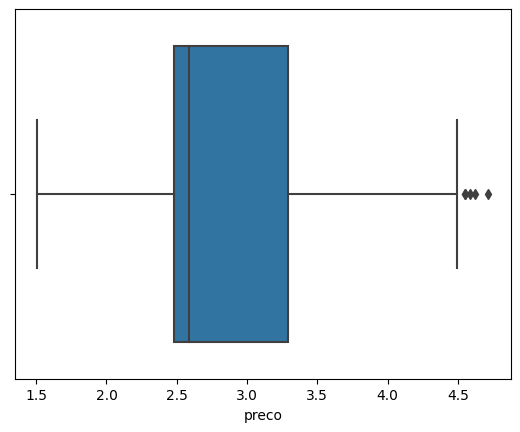

In [ ]:
sns.boxplot(unido_df, x = 'preco');

Podemos notar a existência de alguns Outliers, mas esses valores são possiveis de acontecer.

### Análisando os Preços

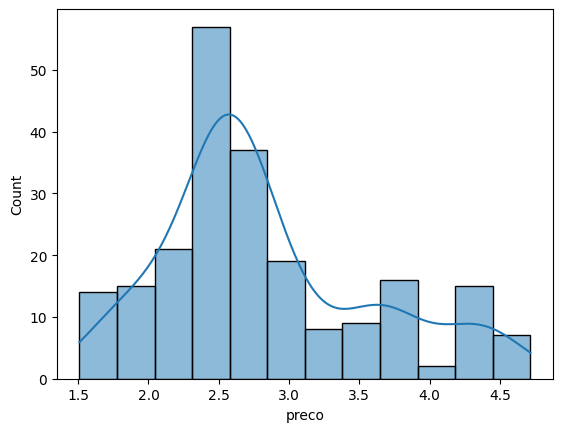

In [ ]:
sns.histplot(unido_df, x = 'preco', kde = True);

Podemos notar que inicialmente os dados tendiam a seguir uma distribuição normal, mas os Outliers acabam tendo uma grande influencia nos preços.

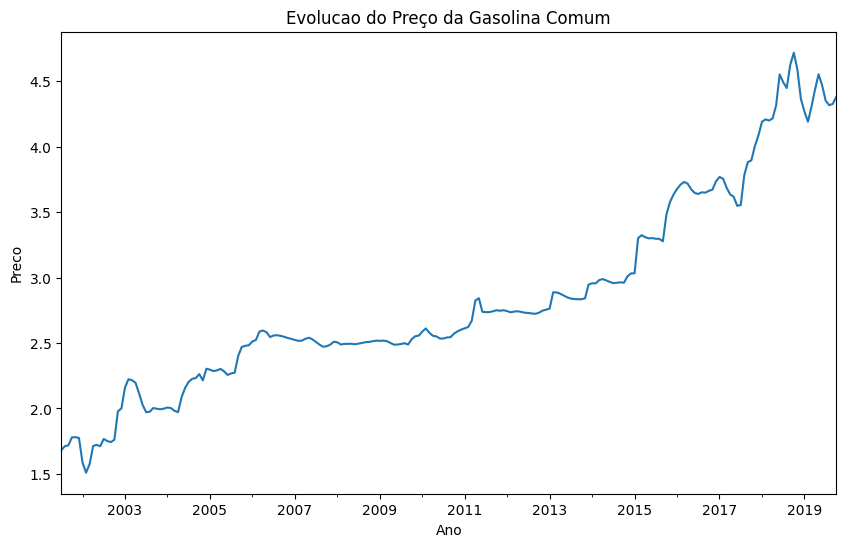

In [ ]:
unido_df.preco.plot(figsize = (10,6))
plt.title('Evolucao do Preço da Gasolina Comum')
plt.xlabel('Ano')
plt.ylabel('Preco')
plt.show();

Podemos notar que a partir de 2015 o preço da Gasolina comum tem um acrescimo em seu valor,chegando ao seu pico em 2018.

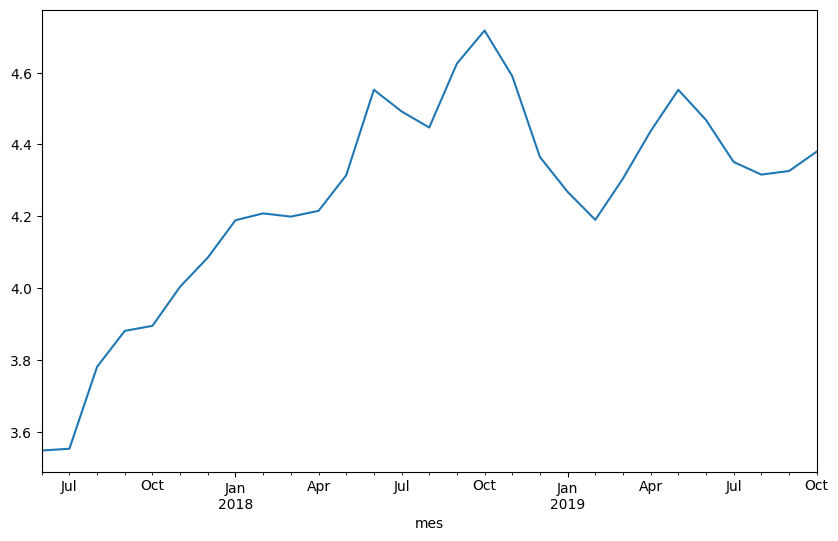

In [ ]:
#Verificando a data exata da alta dos preços da gasolina
pico_datas = unido_df.preco['2017-06-01':'2019-10-01']
pico_datas.plot(figsize = (10,6));

Em outubro de 2018, a Gasolina Comum tem seu maior preço já visto até então.

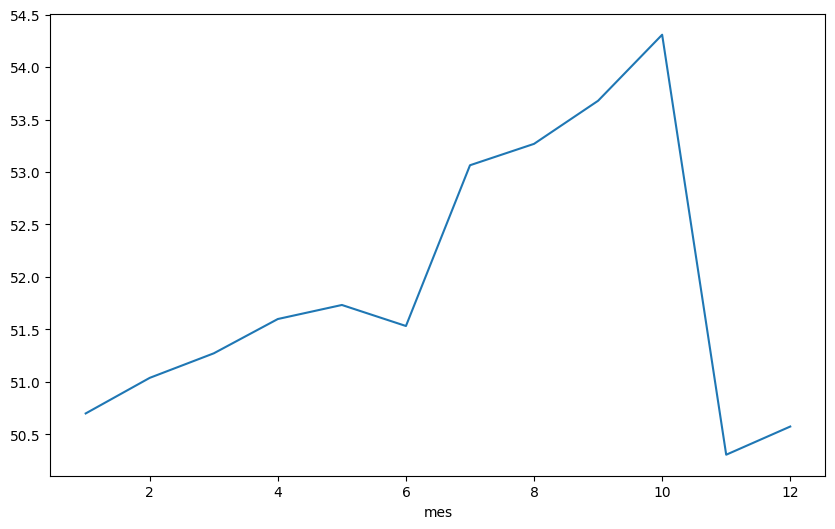

In [ ]:
preco_mes_acu = unido_df.preco.groupby([lambda x: x.month]).sum()
preco_mes_acu.plot(figsize = (10,6));

Podemos notar no gráfico que o pior mês para se comprar gasolina é no mês de Outubro, pois no geral apresenta os valores mais altos.

### Decomposição da série temporal

In [ ]:
decomposicao = seasonal_decompose(unido_df.preco, period = 12)
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

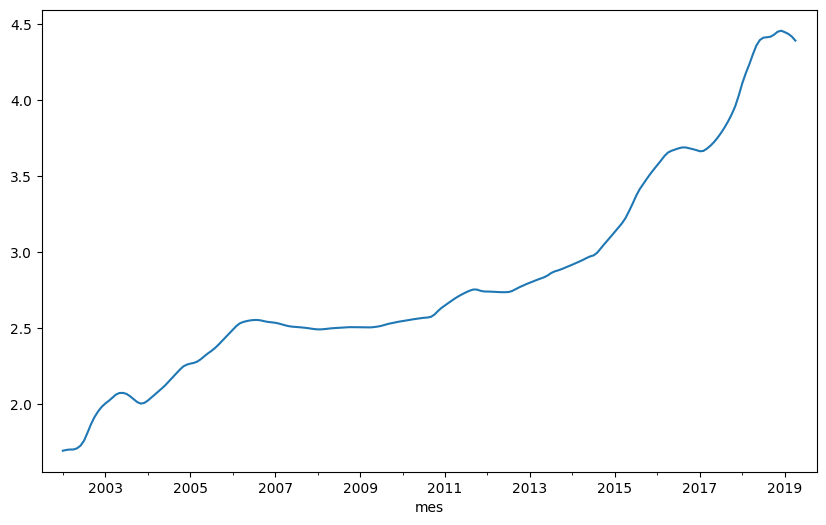

In [ ]:
tendencia.plot(figsize = (10,6));

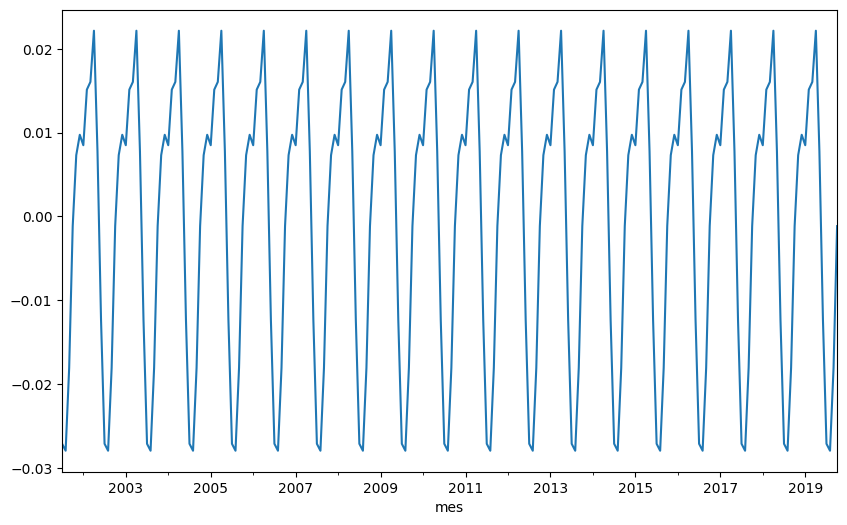

In [ ]:
sazonal.plot(figsize = (10,6));

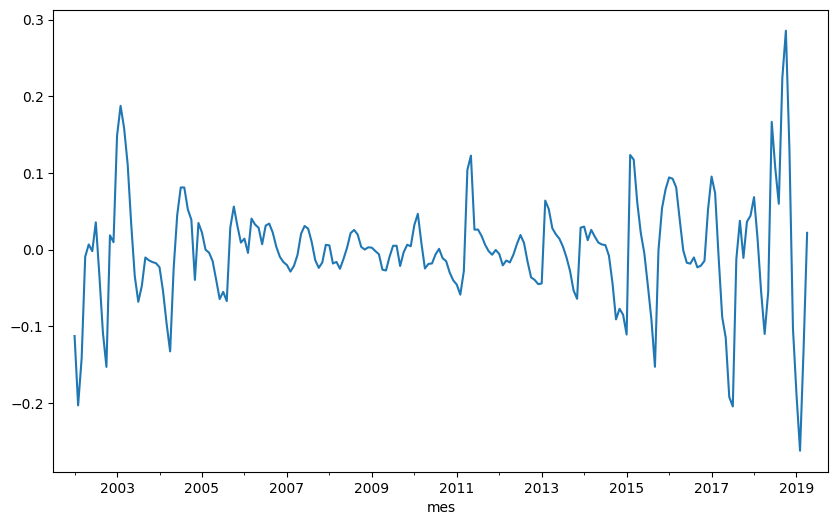

In [ ]:
aleatorio.plot(figsize = (10,6));

Podemos ver no gráfico que a série temporal não é estacionária.

### Autocorrelação Total e Parcial (AR)

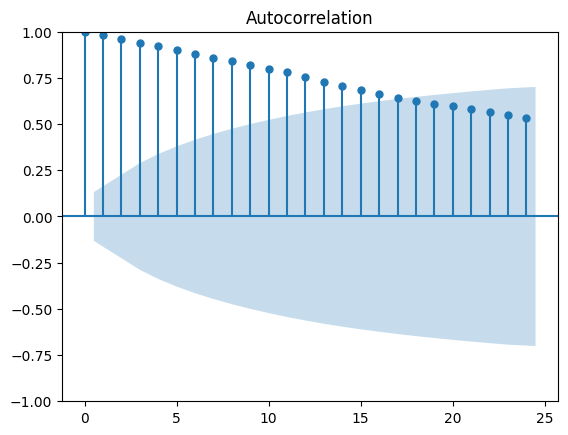

In [ ]:
plot_acf(unido_df.preco)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


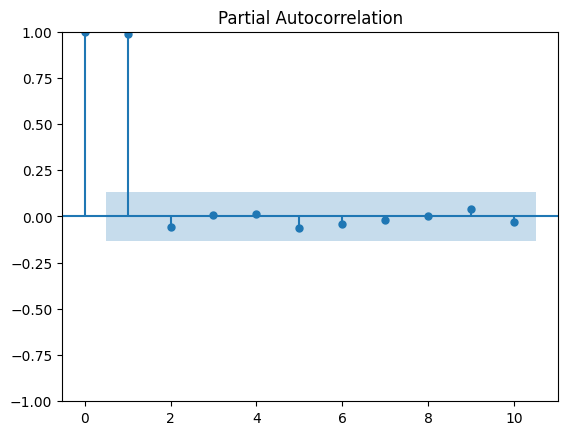

In [ ]:
plot_pacf(unido_df.preco, lags = 10)
plt.show()

A partir do gráfico de Autocorrelação Parcial, Iremos selecionar o P = 1.

## Prevendo com ARIMA

Para confirmar que a série temporal é estacionária iremos realizar um teste: Portante, se o p-valor for menor que 0,05, rejeitamos que a série não é estacionária. Caso seja maior, não podemos descartar que a série não é estacionária

In [ ]:
resultado = adfuller(unido_df['preco'])
print('ADF Statistic: %f' % resultado[0])
print('p-value: %f' % resultado[1])
print('Valores Criticos:')
for key, value in resultado[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.081783
p-value: 0.964795
Valores Criticos:
	1%: -3.461
	5%: -2.875
	10%: -2.574


Para encontrar a melhor ordem para o modelo ARIMA, você pode usar a função auto_arima. Ela busca os melhores valores de p, d e q para o modelo ARIMA.

In [ ]:
model = auto_arima(unido_df, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-425.568, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-504.404, Time=0.91 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.77 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-441.129, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-530.910, Time=2.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.39 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-512.237, Time=1.29 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-537.520, Time=5.21 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-512.270, Time=2.08 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.81 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.71 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-536.262, Time=1.82 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-539.4

In [ ]:
#Criando o modelo com o SARIMAX, que é uma versão do ARIMA com parametros para sazonalidade
modelo = SARIMAX(unido_df,order=(2,1,1),  seasonal_order=(2, 1, 0, 12))
resultado_sarimax = modelo.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
#Resultados do modelo SARIMAX(2,1,1)
print(resultado_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               preco   No. Observations:                  220
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood                 275.711
Date:                             Tue, 25 Jul 2023   AIC                           -539.423
Time:                                     04:03:37   BIC                           -519.426
Sample:                                 07-01-2001   HQIC                          -531.336
                                      - 10-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0005      0.123      8.111      0.000       0.759       1.242
ar.L2         -0.3818      

### Forecast

In [ ]:
#Fazendo uma predição para os próximos 12 meses
forecast = resultado_sarimax.get_forecast(steps=12)

In [ ]:
forecast_medio = forecast.predicted_mean
forecast_medio

2019-11-01    4.448171
2019-12-01    4.507941
2020-01-01    4.564359
2020-02-01    4.557421
2020-03-01    4.532399
2020-04-01    4.526405
2020-05-01    4.568274
2020-06-01    4.616323
2020-07-01    4.580693
2020-08-01    4.669760
2020-09-01    4.789396
2020-10-01    4.839019
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
forecast_medio.size

12

In [ ]:
#Criando o intervalo de confiança das predições
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

In [ ]:
intervalo_abaixo_f[10], intervalo_acima_f[10]

(4.395391358151905, 5.183400378540599)

In [ ]:
#Pegando as datas previstas
datas_forecast = np.asarray(forecast_medio.index)

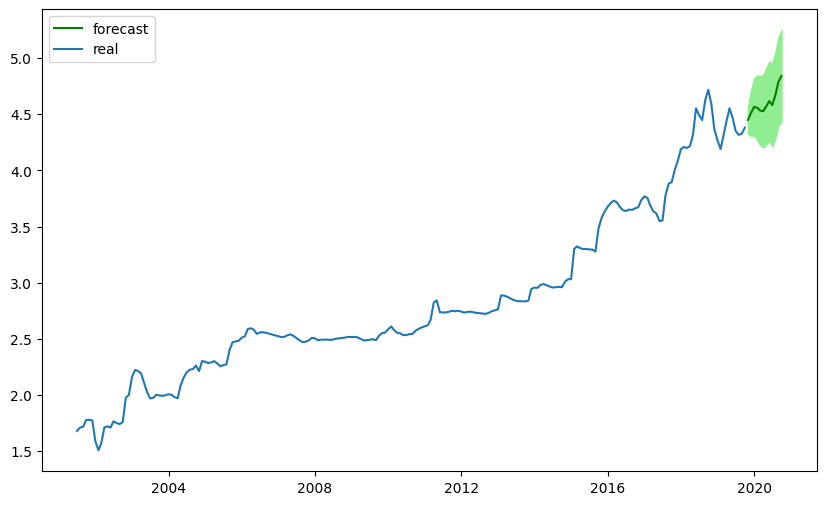

In [ ]:
#Gráfico para a predição feita psrs os 12 meses futuros
dates=np.asarray(unido_df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(dates,unido_df.values, label='real')
plt.legend(loc='upper left')
plt.show()

## Prevendo com XGBoost

In [ ]:
unido_df

,preco
mes,
2001-07-01,1.6814
2001-08-01,1.7110
2001-09-01,1.7180
2001-10-01,1.7787
2001-11-01,1.7802
...,...
2019-06-01,4.4680
2019-07-01,4.3510
2019-08-01,4.3160


In [ ]:
#Separando o Dataframe para o treino e teste do modelo
treino = unido_df.loc[unido_df.index <= '2018-09-30']
teste = unido_df.loc[unido_df.index > '2018-09-30']

In [ ]:
treino.shape, teste.shape

((207, 1), (13, 1))

In [ ]:
#Criando uma nova variavel que irá conter o valor do preço da Gasolina do próximo mês
treino['target'] = treino['preco'].shift(-1)

<ipython-input-133-9caaa4923c81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino['preco'].shift(-1)


In [ ]:
treino

,preco,target
mes,,
2001-07-01,1.6814,1.7110
2001-08-01,1.7110,1.7180
2001-09-01,1.7180,1.7787
2001-10-01,1.7787,1.7802
2001-11-01,1.7802,1.7747
...,...,...
2018-05-01,4.3140,4.5520
2018-06-01,4.5520,4.4920
2018-07-01,4.4920,4.4470


In [ ]:
#Removendo os valores faltantes
treino = treino.dropna()
treino.tail()

,preco,target
mes,,
2018-04-01,4.215,4.314
2018-05-01,4.314,4.552
2018-06-01,4.552,4.492
2018-07-01,4.492,4.447
2018-08-01,4.447,4.625


In [ ]:
teste['target'] = teste['preco'].shift(-1)

<ipython-input-138-00ae71971978>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['target'] = teste['preco'].shift(-1)


In [ ]:
teste

,preco,target
mes,,
2018-10-01,4.717,4.590
2018-11-01,4.590,4.365
2018-12-01,4.365,4.268
2019-01-01,4.268,4.190
2019-02-01,4.190,4.305
2019-03-01,4.305,4.437
2019-04-01,4.437,4.552
2019-05-01,4.552,4.468
2019-06-01,4.468,4.351


In [ ]:
teste = teste.dropna()
teste.tail()

,preco,target
mes,,
2019-05-01,4.552,4.468
2019-06-01,4.468,4.351
2019-07-01,4.351,4.316
2019-08-01,4.316,4.326
2019-09-01,4.326,4.380


In [ ]:
#Separando as bases de treino e teste
X_treino = treino.loc[:, ['preco']].values
y_treino = treino.loc[:, ['target']].values
X_teste = teste.loc[:, ['preco']].values
y_teste = teste.loc[:, ['target']].values

In [ ]:
X_treino.shape, y_treino.shape, X_teste.shape, y_teste.shape

((206, 1), (206, 1), (12, 1), (12, 1))

Validação Cruzada

In [ ]:
#Gridsearch
cv = TimeSeriesSplit(n_splits=5)

In [ ]:
#Disponibilizando os parametros para escolha dos melhores
param = {"learning_rate": [0.1, 0.05],
              #The learning rate is the shrinkage you do at every step you are making

               "gamma" : [0.01, 0.1, 0.3, 0.5],
              #A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
              #Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

               "max_depth": [2, 4, 7, 10],
              #The maximum depth of a tree, same as GBM.
              #Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.

               "colsample_bytree": [0.3, 0.6],
              #Denotes the fraction of columns to be randomly samples for each tree.

               "subsample": [0.2, 0.4, 0.5],
              #Denotes the fraction of observations to be randomly samples for each tree.
              #Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

               "reg_alpha": [0, 0.5, 1],
              #L1 regularization term on weights. Increasing this value will make model more conservative.

               "reg_lambda": [1, 1.5, 2, 3, 4.5],
              #L2 regularization term on weights. Increasing this value will make model more conservative.

               "min_child_weight": [1, 3, 5, 7],
              #The larger min_child_weight is, the more conservative the algorithm will be.

               "n_estimators": [100, 250, 500]}
              #Number of tress or rounds. The more, the higher the risk of overfitting

In [ ]:
#Criando o modelo
xgbr = xgb.XGBRegressor(objective='reg:squarederror' , sampling_method = 'gradient_based', tree_method = 'gpu_hist', enable_categorical=True)

In [ ]:
# Criando o RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgbr,
                              param_distributions=param,
                              verbose=3,
                              random_state=42,
                              cv=cv,
                              error_score='raise'
                              )

In [ ]:
# Fit do modelo
modelo_xgb = xgb_rscv.fit(X_treino, y_treino)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=-9.073 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=-7.683 total time=   0.1s
[CV 3/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=-6.451 total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=-4.098 total time=   0.1s
[CV 5/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.2;, score=-4.82

In [ ]:
#Imprimindo os melhores parametros escolhidos para o modelo
print(modelo_xgb.best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [ ]:
#Criando o modelo com os melhores parametros
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=np.nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=3, sampling_method='gradient_based', scale_pos_weight=1,
             subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None, enable_categorical=True)

In [ ]:
#Fazendo o Fit com os melhores parametros encontrados
reg.fit(X_treino, y_treino, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0.3, gpu_id=0,
             grow_policy=None, importance_type='gain',
             interaction_constraints='', learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=4, max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=2,
             num_parallel_tree=1, predictor=None, random_state=0, ...)

In [ ]:
#Fazendo a previsão
previsao_xgb = reg.predict(X_teste)
previsao_xgb

array([4.3322606, 4.3322606, 4.3322606, 4.2812877, 4.193685 , 4.2812877,
       4.3322606, 4.3322606, 4.3322606, 4.3322606, 4.3322606, 4.3322606],
      dtype=float32)

In [ ]:
y_teste

array([[4.59 ],
       [4.365],
       [4.268],
       [4.19 ],
       [4.305],
       [4.437],
       [4.552],
       [4.468],
       [4.351],
       [4.316],
       [4.326],
       [4.38 ]])

In [ ]:
print('Média dos erros quadrados: {:.2f}'.format(mean_squared_error(y_teste, previsao_xgb)))
print('root mean squared error(RMSE): {:.2f}'.format(sqrt(mean_squared_error(y_teste, previsao_xgb))))

Média dos erros quadrados: 0.02
root mean squared error(RMSE): 0.12
